In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from dotenv import load_dotenv
import os

load_dotenv()

API_KEY = os.getenv('BING_API_KEY')

In [2]:
plt.rcParams = plt.rcParamsOrig

In [3]:
cities = [
    "London",
    "Reading",
    "Bristol",
    "Birmingham",
    "Oxford",
    "Cambridge",
    "Leicester",
    "Sheffield",
    "Manchester",
    "Liverpool",
    "Leeds",
    "Newcastle upon Tyne",
    "Carlisle",
    "Glasgow",
    "Edinburgh"
]

In [4]:
def get_coordinates(city):
    query = f"{city}, United Kingdom"
    url = f"http://dev.virtualearth.net/REST/v1/Locations/{query}?key={API_KEY}"
    resp = requests.get(url)
    data = resp.json()
    obj = data['resourceSets'][0]['resources'][0]
    return obj['name'], obj['point']['coordinates']

def get_distances(locs):
    city_coords = eval(locs.drop('city', axis=1).to_json(orient='records'))
    payload = {
        'origins': city_coords,
        'destinations': city_coords,
        'travelMode': 'driving'
    }
    headers = {
        'Content-Length': '450',
        'Content-Type': 'application/json'
    }
    url = f"https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?key={API_KEY}"
    resp = requests.post(url, json=payload, headers=headers)
    return pd.DataFrame(
        resp.json()['resourceSets'][0]['resources'][0]['results']
    )

In [5]:
from tqdm.notebook import tqdm

locations = []
for city in tqdm(cities):
    locations.append(get_coordinates(city))

In [6]:
locs = pd.DataFrame(
    locations,
    columns=['city', 'coordinates']
)
locs = pd.concat([
    locs[['city']],
    locs['coordinates'].apply(
        pd.Series
    ).rename(
        {
            0: 'latitude',
            1: 'longitude'
        },
        axis=1
    )
], axis=1)
locs['city_name'] = locs['city'].apply(lambda x: x.split(',')[0].strip())

In [7]:
distances = get_distances(locs)
distances['source'] = distances['originIndex'].map(locs.city_name.to_dict())
distances['target'] = distances['destinationIndex'].map(locs.city_name.to_dict())
distances['weight'] = distances['travelDistance']

In [8]:
locs.to_csv('../datasets/uk-coordinates.csv', index=False)
distances.to_csv('../datasets/uk-dist-matrix.csv', index=False)

In [9]:
dist_matrix = distances.pivot_table(
    index='source',
    columns='target',
    values='travelDistance'
)

In [10]:
edges = {
    'London': ['Reading', 'Oxford', 'Cambridge', 'Leicester', 'Birmingham'],
    'Reading': ['Bristol'],
    'Oxford': ['Bristol', 'Birmingham'],
    'Bristol': ['Birmingham'],
    'Cambridge': ['Leicester', 'Sheffield'],
    'Birmingham': ['Leicester', 'Manchester'],
    'Leicester': ['Sheffield'],
    'Sheffield': ['Leeds', 'Manchester'],
    'Leeds': ['Newcastle upon Tyne'],
    'Manchester': ['Liverpool', 'Carlisle', 'Leeds'],
    'Liverpool': ['Carlisle'],
    'Carlisle': ['Glasgow', 'Edinburgh', 'Newcastle upon Tyne'],
    'Glasgow': ['Edinburgh'],
    'Newcastle upon Tyne': ['Edinburgh']
}

In [11]:
routes = []
for source in edges:
    for target in edges[source]:
        routes.append((source, target))

In [12]:
import networkx as nx

G = nx.from_pandas_edgelist(
    distances.merge(
        pd.DataFrame(
            routes,
            columns=['source', 'target']
        ),
        how='inner',
        on=['source', 'target']
    ),
    edge_attr='weight'
)

In [13]:
pos = locs.set_index('city_name').apply(
    lambda x: (x['longitude'], x['latitude']),
    axis=1
).to_dict()

In [14]:
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [15]:
gdf = geopandas.GeoDataFrame(
    locs,
    geometry=geopandas.points_from_xy(
        locs.longitude,
        locs.latitude)
)

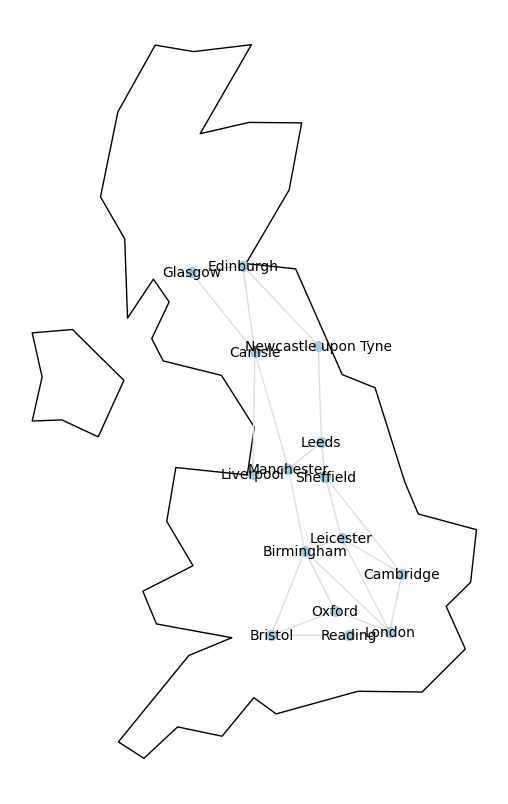

In [16]:
ax = world.query(
    'name == "United Kingdom"'
).plot(
    color='white',
    edgecolor='black',
    figsize=(7, 10)
)

nx.draw(
    G, pos,
    with_labels=True,
    edge_color='#DDDDDD',
    node_color='#A0CBE2',
    node_size=50,
    font_size=10,
    ax=ax
)

# plt.savefig('uk.png', bbox_inches='tight', dpi=200)

In [17]:
%load_ext watermark
%watermark --iversions

pandas    : 1.1.2
numpy     : 1.19.2
geopandas : 0.8.1
requests  : 2.23.0
seaborn   : 0.10.0
matplotlib: 3.2.1
networkx  : 2.4

